In [2]:
%matplotlib inline

In [1]:
import torch
import torch.optim as optim
import tqdm
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [14]:
DEVICE_ID = 3
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [3]:
### Для запуска без GPU раскомментировать и закоментировать код выше
#DEVICE = torch.device('cpu')

In [4]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [6]:
train_path = './homework_4.train.npy'
test_path  = './homework_4_no_classes.test.npy'

In [7]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [8]:
np_mean.shape

(3,)

In [9]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [10]:
dataset_train_norm = CifarDataset(train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test_norm = CifarDataset(test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=164,
                  a_batch_size=128,
                  a_lr=0.1):
    
    train_acc = []
    train_loss = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9, nesterov=True)

    
    for epoch in tqdm.tqdm_notebook(range(a_epochs)):  # loop over the dataset multiple times
        if epoch == 60:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9, nesterov=True) 
        elif epoch == 82:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9, nesterov=True)
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        trainloss=0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)
            
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            trainloss += loss.item()

            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))
        trainloss /= epoch_iters
        train_loss.append(trainloss)
        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch,"Acc", round(train_acc[-1], 4),"Loss",round(train_loss[-1], 4))

    print('Finished Training')
    
    plt.plot(train_acc, label='Train')
    plt.legend()
    plt.grid()

In [11]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        
        if make_downsample: coef = 2
        else: coef = 1  
            
        self.conv1 =  nn.Conv2d(a_in_channels, a_in_channels*coef,  stride = coef,kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(a_in_channels*coef)
        
        self.conv2 =  nn.Conv2d(a_in_channels*coef, a_in_channels*coef, stride = 1,kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(a_in_channels*coef)
        self.make_downsample = make_downsample
        self.downsample = nn.Sequential(nn.Conv2d(a_in_channels, a_in_channels*coef, stride = 2,kernel_size=1, bias=False),
                                        nn.BatchNorm2d(a_in_channels*coef))
 
            
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        
            
        if self.use_skip_connection:
            if self.make_downsample:
                residual = self.downsample(x)
            out += residual
        out = F.relu(out)

        return out

In [12]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
        self.conv = nn.Conv2d(3, 16, 1)
        self.max = nn.MaxPool2d(3,1,1)
        
        self.features = nn.Sequential()
    
        
        self.features.add_module('res_block1', CifarResidualBlock(16))
        self.features.add_module('res_block2', CifarResidualBlock(16))
        self.features.add_module('res_block3', CifarResidualBlock(16))
        self.features.add_module('res_block4', CifarResidualBlock(16))

        self.features.add_module('res_block5', CifarResidualBlock(16,make_downsample=True))
        self.features.add_module('res_block6', CifarResidualBlock(32))
        self.features.add_module('res_block7', CifarResidualBlock(32))
        self.features.add_module('res_block8', CifarResidualBlock(32))
        
        self.features.add_module('res_block9', CifarResidualBlock(32,make_downsample=True))
        self.features.add_module('res_block10', CifarResidualBlock(64))
        self.features.add_module('res_block11', CifarResidualBlock(64))
        self.features.add_module('res_block12', CifarResidualBlock(64))
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size = 8)
        self.fc_classifier = nn.Linear(64, 100)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.max(x)
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)  
        return x

Epoch  0 Acc 0.0865 Loss 3.9257
Epoch  1 Acc 0.1899 Loss 3.2908
Epoch  2 Acc 0.263 Loss 2.9062
Epoch  3 Acc 0.321 Loss 2.6209
Epoch  4 Acc 0.3646 Loss 2.4145
Epoch  5 Acc 0.3987 Loss 2.2439
Epoch  6 Acc 0.428 Loss 2.1306
Epoch  7 Acc 0.4482 Loss 2.0251
Epoch  8 Acc 0.4696 Loss 1.9389
Epoch  9 Acc 0.4886 Loss 1.8588
Epoch  10 Acc 0.5032 Loss 1.8062
Epoch  11 Acc 0.5166 Loss 1.7424
Epoch  12 Acc 0.5298 Loss 1.6945
Epoch  13 Acc 0.5371 Loss 1.655
Epoch  14 Acc 0.5493 Loss 1.6117
Epoch  15 Acc 0.5552 Loss 1.5775
Epoch  16 Acc 0.5635 Loss 1.5521
Epoch  17 Acc 0.5705 Loss 1.5267
Epoch  18 Acc 0.576 Loss 1.4938
Epoch  19 Acc 0.5842 Loss 1.4719
Epoch  20 Acc 0.5904 Loss 1.451
Epoch  21 Acc 0.5941 Loss 1.425
Epoch  22 Acc 0.5994 Loss 1.4072
Epoch  23 Acc 0.6034 Loss 1.3909
Epoch  24 Acc 0.6046 Loss 1.372
Epoch  25 Acc 0.6094 Loss 1.355
Epoch  26 Acc 0.6143 Loss 1.3422
Epoch  27 Acc 0.6181 Loss 1.3355
Epoch  28 Acc 0.6205 Loss 1.3173
Epoch  29 Acc 0.6231 Loss 1.3077
Epoch  30 Acc 0.6265 Loss 1.2

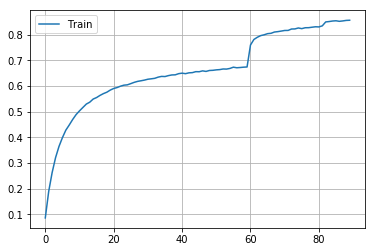

In [15]:
resnet = CifarResNet()
%time train_network(resnet, torch.device(DEVICE), a_epochs = 90)

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [16]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [17]:
my_solution = make_solution(resnet, DEVICE)

In [18]:
with open('my_solution.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)